## Variable meanings

- **Target** = center-cell GOES fire confidence at time `t+1`, converted to binary class
- **Positive class (1)** = `confidence_t+1 >= 0.10`
- **Negative class (0)** = `confidence_t+1 < 0.10`
- **Neighbor features** = all available cell data at time `t` for each of the surrounding 8 cells
- **Variables per neighbor**:
  - `GOES_conf` (GOES fire confidence)
  - `TMP` (RTMA temperature)
  - `WIND` (RTMA wind speed)
  - `WDIR` (RTMA wind direction)
  - `SPFH` (RTMA specific humidity)
  - `ACPC01` (RTMA hourly precipitation)
- **Neighbor order** = `NW, N, NE, W, E, SW, S, SE`
- **Model** = logistic regression (streaming SGD optimization)


## Summary

- Data: GOES hourly confidence (~2 km) + RTMA hourly meteorology
- Task: predict whether next-hour center-cell confidence crosses 0.10 using 8-neighbor features at current hour
- Split: random sample-level train/test split (`70%` train, `30%` test)
- Training: logistic regression on train split only
- Evaluation: held-out test `test_accuracy_overall`, `test_positive_accuracy`, `test_negative_accuracy`


In [32]:
from pathlib import Path
import random

# Fire selection:
# - "all" => run on every fire in data/multi_fire/*
# - list => run only the named fires, e.g. ["Creek", "Dixie"]
FIRE_SELECTION = "all"

# Split and classification settings.
TRAIN_FRACTION = 0.70
POSITIVE_THRESHOLD = 0.10
CLASSIFICATION_PROB_THRESHOLD = 0.50
RUN_SPLIT_SALT = random.randint(0, 2_147_483_647)

print("cwd:", Path.cwd())
print("fire selection:", FIRE_SELECTION)
print("train fraction:", TRAIN_FRACTION)
print("test fraction:", 1.0 - TRAIN_FRACTION)
print("positive confidence threshold:", POSITIVE_THRESHOLD)
print("classification probability threshold:", CLASSIFICATION_PROB_THRESHOLD)
print("split salt:", RUN_SPLIT_SALT)


cwd: /Users/seanmay/Desktop/Current Projects/wildfire-prediction/docs
fire selection: all
train fraction: 0.7
test fraction: 0.30000000000000004
positive confidence threshold: 0.1
classification probability threshold: 0.5
split salt: 1993315273


In [34]:
import json
import hashlib
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import Resampling, reproject
from sklearn.linear_model import SGDClassifier


def parse_iso(value: str) -> datetime:
    if value.endswith("Z"):
        value = value[:-1] + "+00:00"
    return datetime.fromisoformat(value)


def normalize_time_str(value: str) -> str:
    dt = parse_iso(value)
    return dt.strftime("%Y-%m-%dT%H:00:00Z")


def affine_from_list(vals: list) -> rasterio.Affine:
    return rasterio.Affine(vals[0], vals[1], vals[2], vals[3], vals[4], vals[5])


def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data").exists() and (p / "scripts").exists() and (p / "docs").exists():
            return p
    raise FileNotFoundError("Could not find repo root containing data/, scripts/, docs/.")


def load_goes_times(goes_meta: dict, goes_conf: np.ndarray):
    goes_time_steps = goes_meta.get("time_steps", [])
    goes_start = goes_meta.get("start_time")

    if goes_time_steps and isinstance(goes_time_steps[0], (int, float)):
        if not goes_start:
            raise ValueError("GOES time_steps are numeric and metadata.start_time is missing.")
        start_dt = parse_iso(goes_start)
        goes_time_steps = [
            (start_dt + timedelta(hours=int(i - 1))).strftime("%Y-%m-%dT%H:00:00Z")
            for i in goes_time_steps
        ]
    elif not goes_time_steps and goes_start:
        start_dt = parse_iso(goes_start)
        goes_time_steps = [
            (start_dt + timedelta(hours=i)).strftime("%Y-%m-%dT%H:00:00Z")
            for i in range(goes_conf.shape[0])
        ]
    else:
        goes_time_steps = [normalize_time_str(t) for t in goes_time_steps]

    if not goes_time_steps:
        raise ValueError("GOES metadata has no usable time_steps.")

    return goes_time_steps


def discover_fire_entries(repo_root: Path):
    base = repo_root / "data" / "multi_fire"
    if not base.exists():
        raise FileNotFoundError(f"Missing multi-fire directory: {base}")

    entries = []
    for fire_dir in sorted([d for d in base.iterdir() if d.is_dir()]):
        goes_candidates = sorted(fire_dir.glob("*GOES*json"))
        manifest_path = fire_dir / "rtma" / "rtma_manifest.json"
        if not goes_candidates or not manifest_path.exists():
            continue
        entries.append(
            {
                "fire_name": fire_dir.name,
                "goes_json": goes_candidates[0],
                "rtma_manifest": manifest_path,
            }
        )
    return entries


def select_fire_entries(entries, fire_selection):
    if fire_selection is None or fire_selection == "all":
        return entries

    if not isinstance(fire_selection, (list, tuple, set)):
        raise ValueError('FIRE_SELECTION must be "all" or a list/tuple/set of fire names.')

    wanted = {str(x) for x in fire_selection}
    selected = [e for e in entries if e["fire_name"] in wanted]
    found = {e["fire_name"] for e in selected}
    missing = sorted(wanted - found)
    if missing:
        raise ValueError(f"Unknown fire names in FIRE_SELECTION: {missing}")
    return selected


REPO_ROOT = find_repo_root(Path.cwd())


In [35]:
all_fire_entries = discover_fire_entries(REPO_ROOT)
fire_entries = select_fire_entries(all_fire_entries, FIRE_SELECTION)

print("Available fires:", [e["fire_name"] for e in all_fire_entries])
print("Selected fires:", [e["fire_name"] for e in fire_entries])

if len(fire_entries) == 0:
    raise RuntimeError("No fires selected.")


Available fires: ['Creek', 'Dixie', 'LNU_Lightning_Complex', 'North_Complex', 'SCU_Lightning_Complex']
Selected fires: ['Creek', 'Dixie', 'LNU_Lightning_Complex', 'North_Complex', 'SCU_Lightning_Complex']


In [36]:
NEIGHBORS = [
    ("nw", -1, -1),
    ("n", -1, 0),
    ("ne", -1, 1),
    ("w", 0, -1),
    ("e", 0, 1),
    ("sw", 1, -1),
    ("s", 1, 0),
    ("se", 1, 1),
]
VAR_ORDER = ["GOES_conf", "TMP", "WIND", "WDIR", "SPFH", "ACPC01"]
RTMA_VARS_REQUIRED = ["TMP", "WIND", "WDIR", "SPFH", "ACPC01"]


def feature_names():
    names = []
    for n_name, _, _ in NEIGHBORS:
        for v in VAR_ORDER:
            names.append(f"{v}_{n_name}")
    return names


FEATURE_NAMES = feature_names()
N_FEATURES = len(FEATURE_NAMES)


def to_binary_target(y_continuous: np.ndarray, threshold: float) -> np.ndarray:
    return (y_continuous >= threshold).astype(np.int32)


def train_mask_for_hour(fire_name: str, hour_index: int, n_rows: int, train_fraction: float, split_salt: int) -> np.ndarray:
    if not (0.0 < train_fraction < 1.0):
        raise ValueError("TRAIN_FRACTION must be between 0 and 1.")
    key = f"{fire_name}|{hour_index}|{split_salt}".encode("utf-8")
    seed = int.from_bytes(hashlib.sha256(key).digest()[:8], "big") % (2**32 - 1)
    rng = np.random.default_rng(seed)
    random_values = rng.random(n_rows)
    return random_values < train_fraction


def resolve_manifest_file_path(path_str: str, repo_root: Path, manifest_dir: Path) -> Path:
    p = Path(path_str).expanduser()
    if p.exists():
        return p

    parts = p.parts
    if "data" in parts:
        idx = parts.index("data")
        candidate = repo_root.joinpath(*parts[idx:])
        if candidate.exists():
            return candidate

    candidate = (manifest_dir / path_str).resolve()
    if candidate.exists():
        return candidate

    raise FileNotFoundError(f"Could not resolve RTMA part path: {path_str}")


def resample_stack(src_stack, src_transform, src_crs, dst_shape, dst_transform, dst_crs):
    bands = src_stack.shape[0]
    dst = np.empty((bands, dst_shape[0], dst_shape[1]), dtype=np.float32)
    for b in range(bands):
        reproject(
            source=src_stack[b],
            destination=dst[b],
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
        )
    return dst


def build_hour_samples(conf_t, conf_t1, rtma_hour):
    # Use only interior cells so all 8 neighbors exist.
    h, w = conf_t.shape
    if h < 3 or w < 3:
        return np.empty((0, N_FEATURES), dtype=np.float64), np.empty((0,), dtype=np.float64)

    y = conf_t1[1:-1, 1:-1].astype(np.float64)
    feat_blocks = []

    for _, dy, dx in NEIGHBORS:
        ys = slice(1 + dy, h - 1 + dy)
        xs = slice(1 + dx, w - 1 + dx)

        go_n = conf_t[ys, xs].astype(np.float64)
        tmp_n = rtma_hour["TMP"][ys, xs].astype(np.float64)
        wind_n = rtma_hour["WIND"][ys, xs].astype(np.float64)
        wdir_n = rtma_hour["WDIR"][ys, xs].astype(np.float64)
        spfh_n = rtma_hour["SPFH"][ys, xs].astype(np.float64)
        precip_n = rtma_hour["ACPC01"][ys, xs].astype(np.float64)

        feat_blocks.extend([go_n, tmp_n, wind_n, wdir_n, spfh_n, precip_n])

    X = np.stack(feat_blocks, axis=-1).reshape(-1, N_FEATURES)
    y = y.reshape(-1)

    valid = np.isfinite(y)
    valid &= np.isfinite(X).all(axis=1)

    if not valid.any():
        return np.empty((0, N_FEATURES), dtype=np.float64), np.empty((0,), dtype=np.float64)

    return X[valid], y[valid]


def iter_aligned_hours_for_fire(
    goes_conf,
    goes_time_index,
    rtma_manifest,
    rtma_manifest_path: Path,
    goes_shape,
    goes_transform,
    goes_crs,
):
    rtma_vars = rtma_manifest["variables"]
    for req in RTMA_VARS_REQUIRED:
        if req not in rtma_vars:
            raise KeyError(f"RTMA manifest missing required variable: {req}")

    manifest_dir = rtma_manifest_path.parent
    rtma_files = rtma_manifest["files"]
    resolved_files = {
        var: [resolve_manifest_file_path(path, REPO_ROOT, manifest_dir) for path in rtma_files[var]]
        for var in rtma_vars
    }

    n_parts = len(resolved_files[rtma_vars[0]])
    for v in rtma_vars:
        if len(resolved_files[v]) != n_parts:
            raise ValueError("RTMA variable file lists do not have equal part counts.")

    parts = list(zip(*[resolved_files[v] for v in rtma_vars]))
    rtma_time_steps = [normalize_time_str(t) for t in rtma_manifest["time_steps"]]

    rtma_time_ptr = 0

    for part_paths in parts:
        rtma_arrays = {}
        rtma_transform = None
        rtma_crs = None
        band_count = None

        for var, part_path in zip(rtma_vars, part_paths):
            with rasterio.open(part_path) as ds:
                if rtma_transform is None:
                    rtma_transform = ds.transform
                    rtma_crs = ds.crs
                    band_count = ds.count
                rtma_arrays[var] = ds.read().astype("float32")

        if band_count is None:
            continue

        resampled = {}
        for var in rtma_vars:
            resampled[var] = resample_stack(
                rtma_arrays[var],
                rtma_transform,
                rtma_crs,
                goes_shape,
                goes_transform,
                goes_crs,
            )

        for local_idx in range(band_count):
            global_idx = rtma_time_ptr + local_idx
            if global_idx >= len(rtma_time_steps):
                break

            time_str = rtma_time_steps[global_idx]
            if time_str not in goes_time_index:
                continue

            t = goes_time_index[time_str]
            if t + 1 >= goes_conf.shape[0]:
                continue

            rtma_hour = {var: resampled[var][local_idx] for var in RTMA_VARS_REQUIRED}
            yield t, rtma_hour

        rtma_time_ptr += band_count


def iter_fire_hour_samples(entry):
    with Path(entry["goes_json"]).open("r", encoding="utf-8") as f:
        goes_json_local = json.load(f)
    with Path(entry["rtma_manifest"]).open("r", encoding="utf-8") as f:
        rtma_manifest_local = json.load(f)

    goes_conf_local = np.array(goes_json_local["data"], dtype=np.float32)
    goes_meta_local = goes_json_local["metadata"]
    goes_transform_local = affine_from_list(goes_meta_local["geo_transform"])
    goes_crs_local = goes_meta_local.get("crs")
    goes_shape_local = tuple(goes_meta_local["grid_shape"])
    goes_times_local = load_goes_times(goes_meta_local, goes_conf_local)
    goes_time_index_local = {t: i for i, t in enumerate(goes_times_local)}

    for t, rtma_hour in iter_aligned_hours_for_fire(
        goes_conf_local,
        goes_time_index_local,
        rtma_manifest_local,
        Path(entry["rtma_manifest"]),
        goes_shape_local,
        goes_transform_local,
        goes_crs_local,
    ):
        X_hour, y_hour_cont = build_hour_samples(goes_conf_local[t], goes_conf_local[t + 1], rtma_hour)
        if X_hour.shape[0] == 0:
            continue
        y_hour = to_binary_target(y_hour_cont, POSITIVE_THRESHOLD)
        yield entry["fire_name"], t, X_hour, y_hour


print("feature count:", N_FEATURES)
print("first 10 feature names:", FEATURE_NAMES[:10])


feature count: 48
first 10 feature names: ['GOES_conf_nw', 'TMP_nw', 'WIND_nw', 'WDIR_nw', 'SPFH_nw', 'ACPC01_nw', 'GOES_conf_n', 'TMP_n', 'WIND_n', 'WDIR_n']


In [37]:
# Pass 1: split samples into train/test and compute split stats across selected fires.

n_total_samples = 0
n_train_samples = 0
n_test_samples = 0
n_hours_used = 0

train_pos = 0
train_neg = 0
test_pos = 0
test_neg = 0

for entry in fire_entries:
    for fire_name, t, X_hour, y_hour in iter_fire_hour_samples(entry):
        n_hours_used += 1
        n_rows = X_hour.shape[0]
        n_total_samples += n_rows

        mask_train = train_mask_for_hour(fire_name, t, n_rows, TRAIN_FRACTION, RUN_SPLIT_SALT)
        mask_test = ~mask_train

        if mask_train.any():
            y_train = y_hour[mask_train]
            n_train_samples += y_train.shape[0]
            train_pos += int(y_train.sum())
            train_neg += int(y_train.shape[0] - y_train.sum())

        if mask_test.any():
            y_test = y_hour[mask_test]
            n_test_samples += y_test.shape[0]
            test_pos += int(y_test.sum())
            test_neg += int(y_test.shape[0] - y_test.sum())

if n_train_samples == 0:
    raise RuntimeError("No training samples after split.")
if n_test_samples == 0:
    raise RuntimeError("No testing samples after split.")

train_pos_rate = train_pos / n_train_samples
test_pos_rate = test_pos / n_test_samples

print("fires used:", [e["fire_name"] for e in fire_entries])
print("hours used:", n_hours_used)
print("total samples:", n_total_samples)
print("train samples:", n_train_samples)
print("test samples:", n_test_samples)
print("observed train fraction:", n_train_samples / n_total_samples)
print("observed test fraction:", n_test_samples / n_total_samples)
print("train positives:", train_pos, "train negatives:", train_neg, "train pos rate:", train_pos_rate)
print("test positives:", test_pos, "test negatives:", test_neg, "test pos rate:", test_pos_rate)


fires used: ['Creek', 'Dixie', 'LNU_Lightning_Complex', 'North_Complex', 'SCU_Lightning_Complex']
hours used: 4968
total samples: 54964676
train samples: 38479433
test samples: 16485243
observed train fraction: 0.7000756813339535
observed test fraction: 0.2999243186660465
train positives: 113060 train negatives: 38366373 train pos rate: 0.002938192982209483
test positives: 48467 test negatives: 16436776 test pos rate: 0.0029400233894034803


In [38]:
# Pass 2: fit one logistic regression on train split across selected fires.

clf = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=1e-4,
    max_iter=1,
    tol=None,
    random_state=None,
)

classes = np.array([0, 1], dtype=np.int32)
trained = False

for entry in fire_entries:
    for fire_name, t, X_hour, y_hour in iter_fire_hour_samples(entry):
        n_rows = X_hour.shape[0]
        mask_train = train_mask_for_hour(fire_name, t, n_rows, TRAIN_FRACTION, RUN_SPLIT_SALT)
        if not mask_train.any():
            continue

        X_train = X_hour[mask_train]
        y_train = y_hour[mask_train]

        if not trained:
            clf.partial_fit(X_train, y_train, classes=classes)
            trained = True
        else:
            clf.partial_fit(X_train, y_train)

if not trained:
    raise RuntimeError("Model did not receive training data.")

intercept = float(clf.intercept_[0])
coef_std = clf.coef_.ravel()
coef_map = {name: float(val) for name, val in zip(FEATURE_NAMES, coef_std)}

print("intercept:", intercept)
print("coefficient count:", len(coef_map))


intercept: -35.44191111119516
coefficient count: 48


In [39]:
# Pass 3: evaluate on held-out test split across selected fires.

correct_test = 0
count_test_eval = 0

tp = 0
fp = 0
fn = 0
tn = 0

for entry in fire_entries:
    for fire_name, t, X_hour, y_hour in iter_fire_hour_samples(entry):
        n_rows = X_hour.shape[0]
        mask_train = train_mask_for_hour(fire_name, t, n_rows, TRAIN_FRACTION, RUN_SPLIT_SALT)
        mask_test = ~mask_train
        if not mask_test.any():
            continue

        X_test = X_hour[mask_test]
        y_test = y_hour[mask_test]

        prob_test = clf.predict_proba(X_test)[:, 1]
        y_hat = (prob_test >= CLASSIFICATION_PROB_THRESHOLD).astype(np.int32)

        correct_test += int((y_hat == y_test).sum())
        count_test_eval += y_test.shape[0]

        tp += int(((y_hat == 1) & (y_test == 1)).sum())
        fp += int(((y_hat == 1) & (y_test == 0)).sum())
        fn += int(((y_hat == 0) & (y_test == 1)).sum())
        tn += int(((y_hat == 0) & (y_test == 0)).sum())

if count_test_eval == 0:
    raise RuntimeError("No valid evaluation samples in test split.")

test_accuracy_overall = float(correct_test / count_test_eval)
test_positive_accuracy = float(tp / (tp + fn)) if (tp + fn) > 0 else None
test_negative_accuracy = float(tn / (tn + fp)) if (tn + fp) > 0 else None

print("test evaluation samples:", count_test_eval)
print("test accuracy overall:", test_accuracy_overall)
print("test positive accuracy:", test_positive_accuracy)
print("test negative accuracy:", test_negative_accuracy)
print("TP:", tp, "FP:", fp, "FN:", fn, "TN:", tn)


test evaluation samples: 16485243
test accuracy overall: 0.9972748960994994
test positive accuracy: 0.1021107145067778
test negative accuracy: 0.9999144601106689
TP: 4949 FP: 1406 FN: 43518 TN: 16435370


In [40]:
summary_df = pd.DataFrame(
    [
        {
            "model": "logistic_regression",
            "target": "center_confidence_t+1_binary",
            "fires_used_count": len(fire_entries),
            "fires_used": [e["fire_name"] for e in fire_entries],
            "positive_threshold": POSITIVE_THRESHOLD,
            "total_samples": int(n_total_samples),
            "train_samples": int(n_train_samples),
            "test_samples": int(n_test_samples),
            "hours_used": int(n_hours_used),
            "train_fraction": TRAIN_FRACTION,
            "test_fraction": 1.0 - TRAIN_FRACTION,
            "train_positive_rate": train_pos_rate,
            "test_positive_rate": test_pos_rate,
            "test_accuracy_overall": test_accuracy_overall,
            "test_positive_accuracy": test_positive_accuracy,
            "test_negative_accuracy": test_negative_accuracy,
            "tp": int(tp),
            "fp": int(fp),
            "fn": int(fn),
            "tn": int(tn),
            "classification_prob_threshold": CLASSIFICATION_PROB_THRESHOLD,
            "intercept": intercept,
        }
    ]
)
summary_df


,model,target,fires_used_count,fires_used,positive_threshold,total_samples,train_samples,test_samples,hours_used,train_fraction,...,test_positive_rate,test_accuracy_overall,test_positive_accuracy,test_negative_accuracy,tp,fp,fn,tn,classification_prob_threshold,intercept
0,logistic_regression,center_confidence_t+1_binary,5,"[Creek, Dixie, LNU_Lightning_Complex, North_Co...",0.1,54964676,38479433,16485243,4968,0.7,...,0.00294,0.997275,0.102111,0.999914,4949,1406,43518,16435370,0.5,-35.441911


In [41]:
confusion_breakdown_df = pd.DataFrame(
    [
        {
            "true_positives": int(tp),
            "false_positives": int(fp),
            "false_negatives": int(fn),
            "true_negatives": int(tn),
        }
    ]
)
confusion_breakdown_df


,true_positives,false_positives,false_negatives,true_negatives
0,4949,1406,43518,16435370


## Coefficients (top features)


In [42]:
coef_rows = []
for feat, coef in coef_map.items():
    coef_rows.append(
        {
            "feature": feat,
            "coef": coef,
            "odds_ratio": float(np.exp(coef)),
            "abs_coef": abs(coef),
        }
    )

coef_df = pd.DataFrame(coef_rows).sort_values("abs_coef", ascending=False)
coef_top = coef_df.head(20).drop(columns=["abs_coef"])
coef_top


,feature,coef,odds_ratio
18,GOES_conf_w,11.369090,86603.014003
24,GOES_conf_e,11.346817,84695.464937
42,GOES_conf_se,10.992422,59422.107106
0,GOES_conf_nw,10.855733,51830.421550
36,GOES_conf_s,9.523459,13676.839878
6,GOES_conf_n,9.388407,11949.046785
30,GOES_conf_sw,8.040919,3105.467128
12,GOES_conf_ne,7.896998,2689.198055
38,WIND_s,0.616530,1.852489
7,TMP_n,0.443553,1.558233


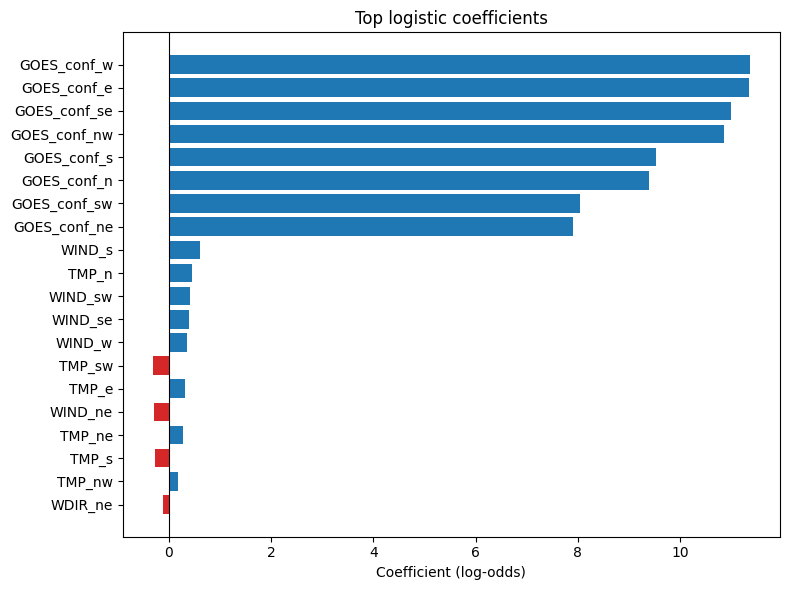

In [43]:
plot_df = coef_df.head(20).iloc[::-1]
colors = ["#1f77b4" if c >= 0 else "#d62728" for c in plot_df["coef"]]

plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature"], plot_df["coef"], color=colors)
plt.axvline(0.0, color="black", linewidth=0.8)
plt.title("Top logistic coefficients")
plt.xlabel("Coefficient (log-odds)")
plt.tight_layout()
plt.show()


In [44]:
report = {
    "model": "logistic_regression",
    "target": "center_confidence_t_plus_1_binary",
    "fires_used": [e["fire_name"] for e in fire_entries],
    "thresholds": {
        "positive_confidence": POSITIVE_THRESHOLD,
        "classification_probability": CLASSIFICATION_PROB_THRESHOLD,
    },
    "split": {
        "train_fraction": TRAIN_FRACTION,
        "test_fraction": 1.0 - TRAIN_FRACTION,
    },
    "feature_order": FEATURE_NAMES,
    "metrics_test": {
        "test_accuracy_overall": test_accuracy_overall,
        "test_positive_accuracy": test_positive_accuracy,
        "test_negative_accuracy": test_negative_accuracy,
        "tp": int(tp),
        "fp": int(fp),
        "fn": int(fn),
        "tn": int(tn),
    },
    "class_balance": {
        "train_positive_rate": train_pos_rate,
        "test_positive_rate": test_pos_rate,
        "train_positives": int(train_pos),
        "train_negatives": int(train_neg),
        "test_positives": int(test_pos),
        "test_negatives": int(test_neg),
    },
    "coefficients": {
        "intercept": intercept,
        "values": coef_map,
    },
    "data": {
        "total_samples": int(n_total_samples),
        "train_samples": int(n_train_samples),
        "test_samples": int(n_test_samples),
        "hours_used": int(n_hours_used),
    },
}

print("Report keys:", list(report.keys()))


Report keys: ['model', 'target', 'fires_used', 'thresholds', 'split', 'feature_order', 'metrics_test', 'class_balance', 'coefficients', 'data']


## Notes and constraints

- GOES confidence is a proxy signal, not direct flame-front geometry.
- This is a linear decision-boundary model (logistic regression), so non-linear effects are not modeled.
- Wind direction is used as raw degrees because the request is to include all available cell data.
- Split is fully random per data point on each run (`rand < 0.7` train, otherwise test).
- `test_positive_accuracy` = `TP / (TP + FN)` and `test_negative_accuracy` = `TN / (TN + FP)`.
- Runtime can be substantial because this uses all samples and multiple passes over all selected fires.
